In [1]:
import numpy as np
import mindspore
import mindspore.nn as nn
import matplotlib.pyplot as plt
from mindspore import Tensor

In [2]:
def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [3]:
class Word2Vec(nn.Cell):
    def __init__(self, voc_size, embed_size):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Dense(voc_size, embed_size, has_bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Dense(embed_size, voc_size, has_bias=False) # embedding_size > voc_size Weight
        
    def construct(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

In [4]:
batch_size = 2 # mini-batch size
embed_size = 2 # embedding size

sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
             "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

In [5]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for w in context:
        skip_grams.append([target, w])

In [6]:
model = Word2Vec(voc_size, embed_size)

In [7]:
criterion = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.001)

In [8]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE) # GRAPH_MODE

net_with_criterion = nn.WithLossCell(model, criterion)
train_network = nn.TrainOneStepCell(net_with_criterion, optimizer)
train_network.set_train()

TrainOneStepCell<
  (network): WithLossCell<
    (_backbone): Word2Vec<
      (W): Dense<input_channels=8, output_channels=2>
      (WT): Dense<input_channels=2, output_channels=8>
      >
    (_loss_fn): SoftmaxCrossEntropyWithLogits<>
    >
  (optimizer): Adam<>
  >

In [9]:
epoch = 5000
for step in range(epoch):
    input_batch, target_batch = random_batch()
    input_batch = Tensor(input_batch, mindspore.float32)
    target_batch = Tensor(target_batch, mindspore.int32)
    loss = train_network(input_batch, target_batch)
    if (step + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (step + 1), 'cost = ', '{:.6f}'.format(loss.asnumpy()))

[WARNING] DEBUG(12994,0x106d88600,python):2022-01-23-19:42:03.399.128 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.


Epoch: 1000 cost =  1.912153
Epoch: 2000 cost =  1.404567
Epoch: 3000 cost =  0.863563
Epoch: 4000 cost =  0.763451
Epoch: 5000 cost =  1.141458


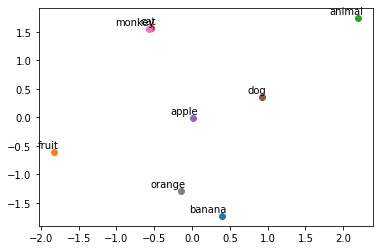

In [10]:
for i, label in enumerate(word_list):
    W, WT = model.get_parameters()
    x, y = W[0][i].asnumpy(), W[1][i].asnumpy()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()